In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

/Users/jingyiliu/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [14]:
# Load dataset
file_path = "cleaned_data.csv"  # Change to your actual file

df = pd.read_csv(file_path)

# Define features and target
feature_columns = [col for col in df.columns if col not in ["left", "right"]]
target_columns = ["left", "right"]

X = df[feature_columns].values  # Extract features
y = df[target_columns].values   # Extract target labels (binary classification)

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Reshape data for LSTM: (samples, timesteps, features)
sequence_length = 273  # Number of past time steps used for prediction
X_lstm = []
y_lstm = []

for i in range(len(X_scaled) - sequence_length):
    X_lstm.append(X_scaled[i:i + sequence_length])  # Create sequences
    y_lstm.append(y[i + sequence_length])  # Corresponding labels

X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

# Define LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(sequence_length, X_lstm.shape[2])),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(2, activation='sigmoid')  # Two output neurons for left & right foot contact
])

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_lstm, y_lstm, epochs=20, batch_size=32, validation_split=0.2)

# Save the model
model.save("lstm_foot_contact_model.h5")

print("Model training complete!")



/Users/jingyiliu/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
1077/1077 ━━━━━━━━━━━━━━━━━━━━ 84s 77ms/step - accuracy: 0.9062 - loss: 0.1625 - val_accuracy: 0.9868 - val_loss: 0.0318
Epoch 2/20
1077/1077 ━━━━━━━━━━━━━━━━━━━━ 81s 76ms/step - accuracy: 0.9439 - loss: 0.0366 - val_accuracy: 0.9794 - val_loss: 0.0428
Epoch 3/20
1077/1077 ━━━━━━━━━━━━━━━━━━━━ 81s 75ms/step - accuracy: 0.9549 - loss: 0.0311 - val_accuracy: 0.9894 - val_loss: 0.0263
Epoch 4/20
1077/1077 ━━━━━━━━━━━━━━━━━━━━ 81s 75ms/step - accuracy: 0.9778 - loss: 0.0331 - val_accuracy: 0.9892 - val_loss: 0.0256
Epoch 5/20
1077/1077 ━━━━━━━━━━━━━━━━━━━━ 82s 76ms/step - accuracy: 0.9837 - loss: 0.0303 - val_accuracy: 0.9770 - val_loss: 0.0530
Epoch 6/20
1077/1077 ━━━━━━━━━━━━━━━━━━━━ 81s 75ms/step - accuracy: 0.9703 - loss: 0.0284 - val_accuracy: 0.9885 - val_loss: 0.0266
Epoch 7/20
1077/1077 ━━━━━━━━━━━━━━━━━━━━ 81s 75ms/step - accuracy: 0.9805 - loss: 0.0267 - val_accuracy: 0.9783 - val_loss: 0.0482
Epoch 8/20
1077/1077 ━━━━━━━━━━━━━━━━━━━━ 81s 75ms/step - accuracy: 0.9669 -

Model training complete!


In [15]:
# Make predictions
y_pred = model.predict(X_lstm)

# Convert probabilities to binary (0 or 1)
y_pred_binary = (y_pred > 0.5).astype(int)


1346/1346 ━━━━━━━━━━━━━━━━━━━━ 25s 19ms/step


In [26]:
import matplotlib.pyplot as plt

# Get training history
history = model.history.history

# # Plot Loss
# plt.figure(figsize=(10, 4))
# plt.plot(history['loss'], label='Training Loss')
# plt.plot(history['val_loss'], label='Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.title('Loss Curve')
# plt.show()

# # Plot Accuracy
# plt.figure(figsize=(10, 4))
# plt.plot(history['accuracy'], label='Training Accuracy')
# plt.plot(history['val_accuracy'], label='Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.title('Accuracy Curve')
# plt.show()


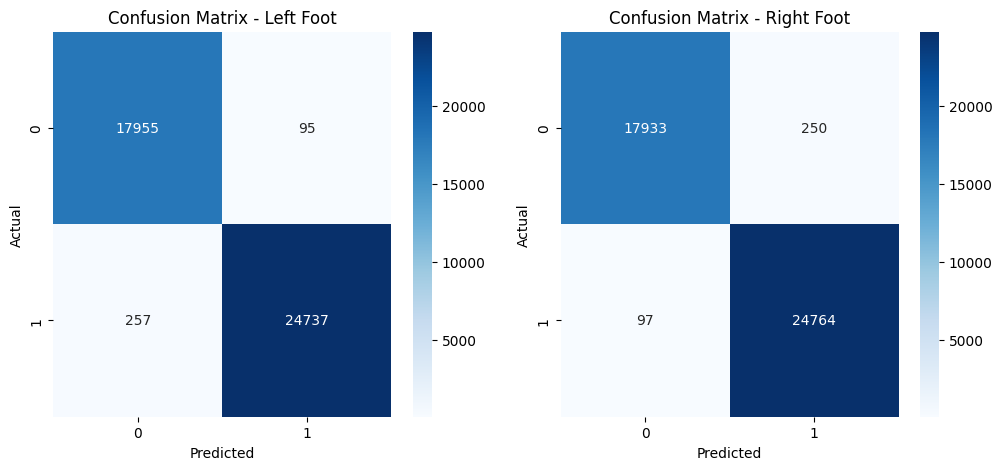

In [18]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Compute confusion matrix for "left" foot contact
cm_left = confusion_matrix(y_lstm[:, 0], y_pred_binary[:, 0])
cm_right = confusion_matrix(y_lstm[:, 1], y_pred_binary[:, 1])

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_left, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("Confusion Matrix - Left Foot")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(cm_right, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title("Confusion Matrix - Right Foot")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.show()


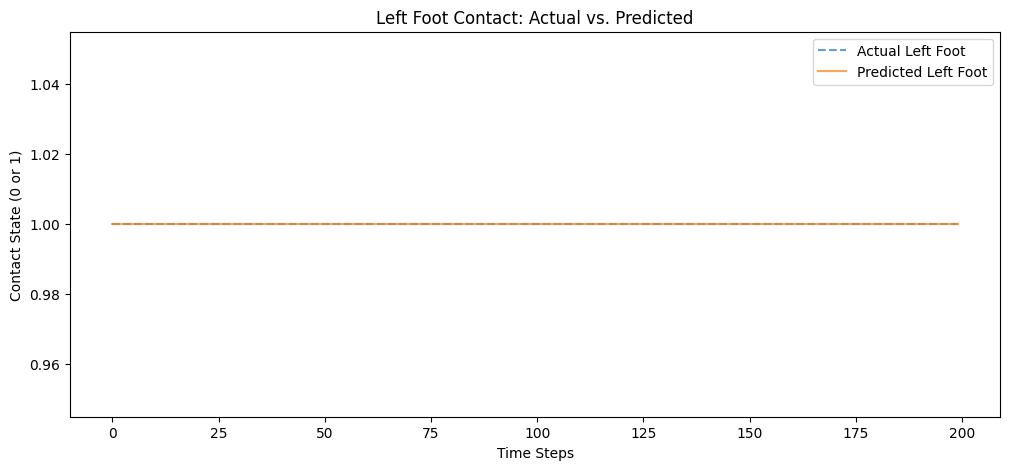

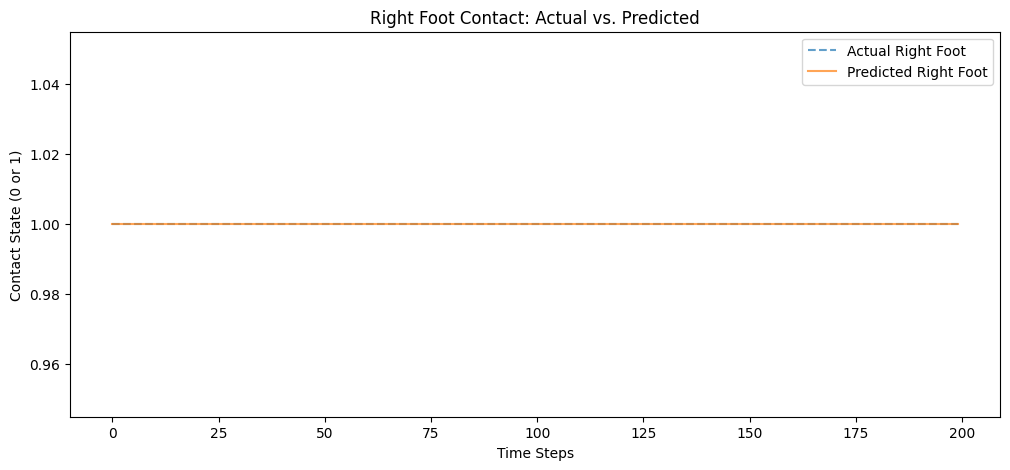

In [19]:
plt.figure(figsize=(12, 5))

# Plot left foot contact
plt.plot(y_lstm[:200, 0], label="Actual Left Foot", linestyle="dashed", alpha=0.7)
plt.plot(y_pred_binary[:200, 0], label="Predicted Left Foot", alpha=0.7)

plt.legend()
plt.xlabel("Time Steps")
plt.ylabel("Contact State (0 or 1)")
plt.title("Left Foot Contact: Actual vs. Predicted")
plt.show()

# Plot right foot contact
plt.figure(figsize=(12, 5))
plt.plot(y_lstm[:200, 1], label="Actual Right Foot", linestyle="dashed", alpha=0.7)
plt.plot(y_pred_binary[:200, 1], label="Predicted Right Foot", alpha=0.7)

plt.legend()
plt.xlabel("Time Steps")
plt.ylabel("Contact State (0 or 1)")
plt.title("Right Foot Contact: Actual vs. Predicted")
plt.show()


In [20]:
print("Left Foot Contact Classification Report:")
print(classification_report(y_lstm[:, 0], y_pred_binary[:, 0]))

print("Right Foot Contact Classification Report:")
print(classification_report(y_lstm[:, 1], y_pred_binary[:, 1]))


Left Foot Contact Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     18050
           1       1.00      0.99      0.99     24994

    accuracy                           0.99     43044
   macro avg       0.99      0.99      0.99     43044
weighted avg       0.99      0.99      0.99     43044

Right Foot Contact Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     18183
           1       0.99      1.00      0.99     24861

    accuracy                           0.99     43044
   macro avg       0.99      0.99      0.99     43044
weighted avg       0.99      0.99      0.99     43044

